# Ergodicity - comparison of the ensemble and the time averaged mean square displacement achieved from SDEs

## Import libraries and dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections
from matplotlib import rc
import os
import sys
sys.path.append("../")

from scipy import stats
from scipy.optimize import curve_fit
from scipy.linalg import norm

from config import results_folder, plots_folder

## Plot details

In [2]:
plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 4
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath} \usepackage{bm}"]

## Utility functions

In [3]:
def read_and_return_msd_data(filenames, timestep, t_stop, runs):
    times = np.arange(0, (int(t_stop/timestep)+1))*timestep
    ensemble_msd_matrix = np.zeros((runs, int(t_stop/timestep)+1))
    ta_msd_matrix = np.zeros((runs, int(t_stop/timestep)+1))
    mss_matrix = np.zeros((runs, int(t_stop/timestep)+1))
    for i in range(runs):
        filename = filenames.replace('X', str(i))
        msd_data = np.load(file=os.path.join(results_folder, filename))
        ensemble_msd_matrix[i, :] = msd_data[:, 1]
        ta_msd_matrix[i, :] = msd_data[:, 2]
        mss_matrix[i, :] = msd_data[:, 3]
    return times, np.mean(ensemble_msd_matrix, axis=0), np.std(ensemble_msd_matrix, axis=0), np.mean(ta_msd_matrix, axis=0), np.std(ta_msd_matrix, axis=0), np.mean(mss_matrix, axis=0), np.std(mss_matrix, axis=0)

In [4]:
def log_function(t, scaling_factor):
    return np.log(t)*scaling_factor

In [5]:
def slope_function(t, scaling_factor):
    return t*scaling_factor

In [6]:
def tau_analytical(T0, xi, N, r, m=1):
    # Num and exp result China + Brilliantov and Poshel with a2=0
    n = N/1
    eta = n*4*np.pi*r**3/3
    g = (2-eta)/(2*(1-eta)**3)
    return (np.sqrt(T0/m)*(1-xi**2)/6*4*np.sqrt(np.pi)*g*(2*r)**2*n)**(-1)

def D0(T0, xi, N, r, m):
    n = N/1
    eta = n*4*np.pi*r**3/3
    g = (2-eta)/(2*(1-eta)**3)
    return 3*np.sqrt(T0)/((1+xi)**2*np.sqrt(m*np.pi)*n*g*(2*r)**2*2)

def gamma_1(T0, d0, m):
    return T0/(d0*m)

In [7]:
def msd_gg(t, d0, gamma0, tau):
    msd_1d = 2*d0*tau*(np.log(1+t/tau)+(1/(tau*gamma0))*((1+t/tau)**(-tau*gamma0)-1))
    return 3*msd_1d

def msd_udsbm(t, d0, gamma0, tau):
    msd_1d = 2*d0*tau**2*gamma0**2*(tau*np.log(1+t/tau)+(tau/(tau*gamma0-1))*((1+t/tau)**(-tau*gamma0+1)-1))/((tau*gamma0-1)**2)
    return 3*msd_1d

def msd_elasticparticles(t, d0, gamma0):
    msd_1d = 2*d0*t+2*d0*(np.exp(-gamma0*t)-1)/gamma0
    return 3*msd_1d

In [8]:
def check_convergence(times, std_ensemble_msd, deltas, std_ta_msd, runs):
    # Error is given by Central limit theorem
    plt.figure()
    plt.loglog(times, std_ensemble_msd/np.sqrt(runs), label='Ensemble average')
    plt.loglog(deltas, std_ta_msd/np.sqrt(runs), label='Time average')
    plt.title('Standard deviation computed from clt')
    plt.xlabel(r'$t, \Delta$')
    plt.ylabel(r'$STD$')
    plt.legend()
    plt.show()

## Mean square displacement and temperature for granular gas

In [9]:
def compare_ensemble_and_time_averaged_msd(N, xi, r, tstop, timestep, runs=4):
    filenames = f"ergodicity_msd_sde_N_{N}_r_{r}_xi_{xi}_tstop_{tstop}_dt_{timestep}_X.npy"

    print(filenames)
    print(f'---------- xi: {xi} ------------')
    times, ensemble_msd, std_ensemble_msd, ta_msd, std_ta_msd, mss, std_mss = read_and_return_msd_data(filenames, timestep, tstop, runs)
    
    T0 = mss[0]/3
    
    times = times[1:]
    ensemble_msd = ensemble_msd[1:]
    std_ensemble_msd = std_ensemble_msd[1:]
    # for time averaged values delta equal to tmax is not defined
    deltas = times[:-1]
    ta_msd = ta_msd[1:-1]
    std_ta_msd = std_ta_msd[1:-1]
    mss = mss[1:]
    std_mss = std_mss[1:]
    
    check_convergence(times, std_ensemble_msd, deltas, std_ta_msd, runs)
    
    plt.figure()
    
    plt.loglog(times, ensemble_msd, label='Ensemble MSD')
    plt.loglog(deltas, ta_msd, label='Time averaged MSD')
    
    plt.xlabel(r'$t, \Delta$')
    plt.ylabel(r'$\langle (\bm{x}(t)-\bm{x}_0)^2 \rangle, \langle \overline{\bm{\delta}^2(\Delta)} \rangle$')
    #plt.title(r'$\xi={}$'.format(xi))
    plt.legend()
    plt.savefig(os.path.join(plots_folder, f"ergodicity_sde_N_{N}_xi_{xi}_rad_{r}_tstop_{tstop}.pdf"))
    plt.show()
    print('-----------------------')

In [10]:
def compare_tstop_time_average_msd(N, xi, r, tstop_values, timestep, runs=4):
    print(f'---------- xi: {xi} ------------')
    plt.figure()
    for tstop in tstop_values:
        filenames = f"ergodicity_msd_sde_N_{N}_r_{r}_xi_{xi}_tstop_{tstop}_dt_{timestep}_X.npy"

        print(filenames)

        times, ensemble_msd, std_ensemble_msd, ta_msd, std_ta_msd, mss, std_mss = read_and_return_msd_data(filenames, timestep, tstop, runs)

        times = times[1:]
        ensemble_msd = ensemble_msd[1:]
        std_ensemble_msd = std_ensemble_msd[1:]
        # for time averaged values delta equal to tmax is not defined
        deltas = times[:-1]
        ta_msd = ta_msd[1:-1]
        std_ta_msd = std_ta_msd[1:-1]
        mss = mss[1:]
        std_mss = std_mss[1:]
    
        plt.loglog(deltas, ta_msd, label=r'$t_{stop}=$'+r'${}$'.format(tstop))
    
    plt.xlabel(r'$\Delta$')
    plt.ylabel(r'$\langle \overline{\bm{\delta}^2(\Delta)} \rangle$')
    #plt.title(r'$\xi={}$'.format(xi))
    plt.legend()
    plt.savefig(os.path.join(plots_folder, f"time_average_msd_diff_tstop_sde_N_{N}_xi_{xi}_rad_{r}.pdf"))
    plt.show()
    print('-----------------------')

### Molecular gas of elastic particles (xi = 1)

ergodicity_msd_sde_N_1000_r_0.025_xi_1.0_tstop_10_dt_0.01_X.npy
---------- xi: 1.0 ------------


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


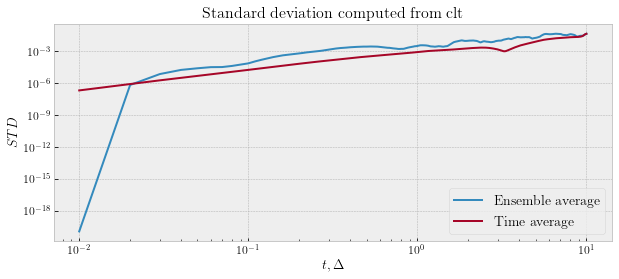

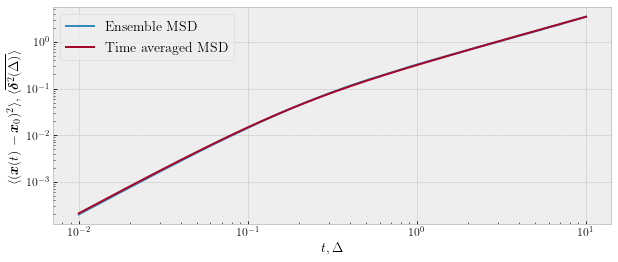

-----------------------


In [11]:
N = 1000
xi = 1.0
tstop = 10
rad = 0.025
timestep = 0.01
number_of_runs = 4

compare_ensemble_and_time_averaged_msd(N, xi, rad, tstop, timestep, number_of_runs)

ergodicity_msd_sde_N_1000_r_0.025_xi_1.0_tstop_100_dt_0.01_X.npy
---------- xi: 1.0 ------------


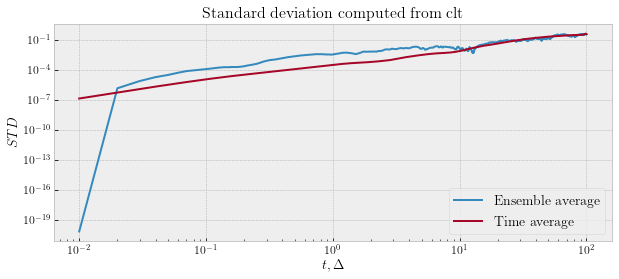

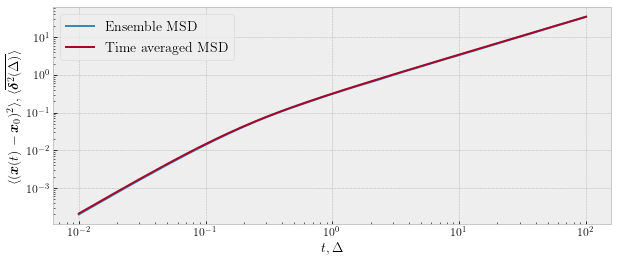

-----------------------


In [12]:
tstop = 100

compare_ensemble_and_time_averaged_msd(N, xi, rad, tstop, timestep, number_of_runs)

### Granular gas of inelastic particles (xi < 1)

ergodicity_msd_sde_N_1000_r_0.025_xi_0.8_tstop_10_dt_0.01_X.npy
---------- xi: 0.8 ------------


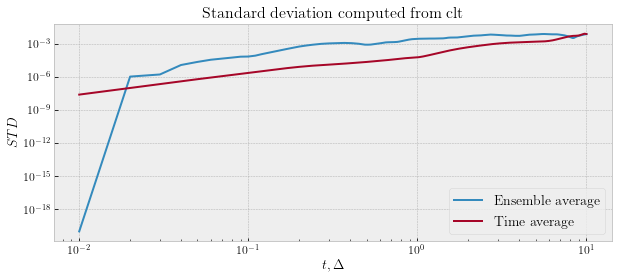

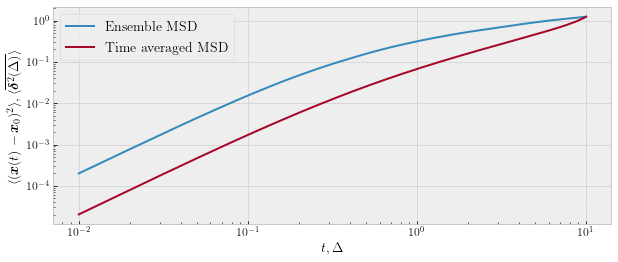

-----------------------


In [13]:
N = 1000
xi = 0.8
tstop = 10
rad = 0.025
timestep = 0.01
number_of_runs = 4

compare_ensemble_and_time_averaged_msd(N, xi, rad, tstop, timestep, number_of_runs)

ergodicity_msd_sde_N_1000_r_0.025_xi_0.8_tstop_100_dt_0.01_X.npy
---------- xi: 0.8 ------------


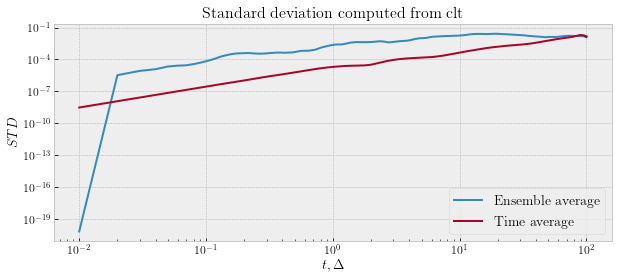

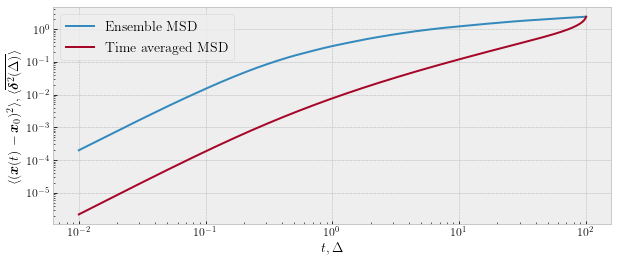

-----------------------


In [14]:
tstop = 100

compare_ensemble_and_time_averaged_msd(N, xi, rad, tstop, timestep, number_of_runs)

---------- xi: 0.8 ------------
ergodicity_msd_sde_N_1000_r_0.025_xi_0.8_tstop_10_dt_0.01_X.npy
ergodicity_msd_sde_N_1000_r_0.025_xi_0.8_tstop_100_dt_0.01_X.npy


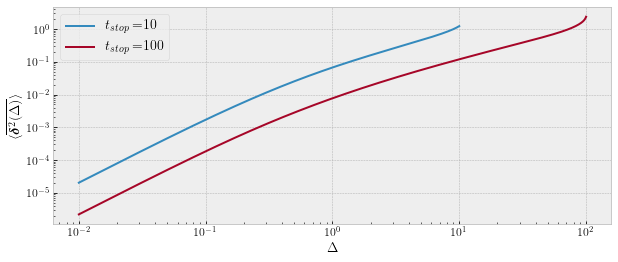

-----------------------


In [15]:
compare_tstop_time_average_msd(N, xi, rad, [10, 100], timestep, number_of_runs)